# 📚 Transformer Modelleri ile İleri Seviye NLP: Soru Cevaplama ve Metin Özetleme

## 🎯 Ders İçeriği

Bu kapsamlı derste şunları öğreneceksiniz:

### 1️⃣ **Soru Cevaplama (Question Answering)**
- BERT ile Ekstraktif Soru Cevaplama
- T5 ile Generatif Soru Cevaplama
- Pipeline API kullanımı
- Gerçek dünya uygulamaları

### 2️⃣ **Metin Özetleme (Text Summarization)**
- Ekstraktif Özetleme (Sumy ile)
- Abstraktif Özetleme (BART, T5, Pegasus ile)
- Farklı modellerin karşılaştırması
- Pratik uygulamalar

### 3️⃣ **Gerçek Veri Seti Uygulamaları**
- BBC News Dataset ile uygulamalı örnekler
- Model performans değerlendirmeleri
- İleri seviye optimizasyon teknikleri

---

## 📋 Gereksinimler

```
transformers >= 4.30.0
torch >= 2.0.0
datasets >= 2.14.0
sumy >= 0.11.0
nltk >= 3.8.0
pandas >= 2.0.0
matplotlib >= 3.7.0
rouge-score >= 0.1.2
```

---

**👨‍🏫 Eğitmen Notu:** Bu notebook, sıfırdan ileri seviyeye kadar adım adım ilerleyen bir yapıdadır. Her hücreyi sırasıyla çalıştırmanız önerilir.

# 🔍 BÖLÜM 1: Soru Cevaplama (Question Answering)

## 📖 Soru Cevaplama Nedir?

**Soru Cevaplama (QA)**, verilen bir metin (context) içerisinden, sorulan sorunun cevabını otomatik olarak bulan bir NLP görevidir.

### 🎭 QA Türleri:

1. **Ekstraktif QA (Extractive QA)**
   - Cevap, verilen metinden doğrudan alınır
   - BERT, RoBERTa, ELECTRA gibi modeller kullanılır
   - SQuAD veri seti ile eğitilmiş modeller yaygındır

2. **Generatif QA (Generative QA)**
   - Model, cevabı kendi üretir
   - T5, GPT, BART gibi modeller kullanılır
   - Daha esnek ve yaratıcı cevaplar üretebilir

3. **Açık Alan QA (Open-Domain QA)**
   - Belirli bir context olmadan, genel bilgiyle cevap verir
   - Bilgi erişim (Information Retrieval) ile birleştirilir

---

## 🏆 Popüler QA Veri Setleri

- **SQuAD (Stanford Question Answering Dataset)**: 100,000+ soru-cevap çifti
- **Natural Questions**: Google arama sorguları
- **TriviaQA**: Trivia soruları ve kanıtlar
- **HotpotQA**: Çok-adımlı mantıksal soru cevaplama

---

In [1]:
# ============================================================================
# KÜTÜPHANE YÜKLEMELERİ VE AYARLAR
# ============================================================================

# Transformers kütüphanesi: Hugging Face'in dönüştürücü model kütüphanesi
from transformers import (
    BertTokenizer, BertForQuestionAnswering,
    T5Tokenizer, T5ForConditionalGeneration,
    pipeline,
    AutoTokenizer, AutoModelForQuestionAnswering
)

# PyTorch: Derin öğrenme framework'ü
import torch

# Veri işleme ve görselleştirme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Uyarı mesajlarını filtreleme
import warnings
warnings.filterwarnings('ignore')

# Plot ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Türkçe karakter desteği için
plt.rcParams['font.family'] = 'DejaVu Sans'

print("✅ Tüm kütüphaneler başarıyla yüklendi!")
print(f"🔥 PyTorch Versiyonu: {torch.__version__}")
print(f"🤗 Transformers Kütüphanesi: Hazır")
print(f"💻 Cihaz: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

✅ Tüm kütüphaneler başarıyla yüklendi!
🔥 PyTorch Versiyonu: 2.8.0+cu126
🤗 Transformers Kütüphanesi: Hazır
💻 Cihaz: CPU


## 🤖 BERT ile Ekstraktif Soru Cevaplama

### 📌 BERT (Bidirectional Encoder Representations from Transformers)

**BERT'in Özellikleri:**
- Google tarafından 2018'de geliştirildi
- Çift yönlü (bidirectional) context anlama
- Masked Language Modeling (MLM) ile pre-training
- Transfer learning için mükemmel bir temel

### 🎯 Kullanacağımız Model: `deepset/bert-base-cased-squad2`

**Model Özellikleri:**
- ✅ BERT-base mimarisi (12 layer, 768 hidden size, 12 attention heads)
- ✅ SQuAD 2.0 veri seti ile fine-tune edilmiş
- ✅ 100M+ parametre
- ✅ Cevapsız sorular için "impossible" tespiti yapabilir
- ✅ Case-sensitive (büyük/küçük harf duyarlı)

**SQuAD 2.0 Performansı:**
- F1 Score: ~80%
- Exact Match: ~77%

---

In [2]:
# ============================================================================
# BERT MODELİNİ VE TOKENIZER'I YÜKLEME
# ============================================================================

# Model adı: deepset/bert-base-cased-squad2
# Bu model, SQuAD 2.0 dataset'i ile fine-tune edilmiş bir BERT modelidir
model_name = 'deepset/bert-base-cased-squad2'

print("📥 Model ve Tokenizer yükleniyor...")
print(f"📌 Model: {model_name}")

# Tokenizer: Metni BERT'in anlayabileceği token'lara dönüştürür
# - WordPiece tokenization kullanır
# - Özel tokenlar: [CLS], [SEP], [PAD], [MASK]
tokenizer_bert = BertTokenizer.from_pretrained(model_name)

# Model: Soru cevaplama için önceden eğitilmiş BERT modeli
# - Question Answering head'i ile birlikte gelir
# - Start ve End position'ları tahmin eder
model_bert = BertForQuestionAnswering.from_pretrained(model_name)

print("✅ Model başarıyla yüklendi!")
print(f"📊 Model Parametreleri: {sum(p.numel() for p in model_bert.parameters()):,}")
print(f"🔤 Vocabulary Boyutu: {len(tokenizer_bert):,}")
print(f"📏 Max Sequence Length: {tokenizer_bert.model_max_length}")

📥 Model ve Tokenizer yükleniyor...
📌 Model: deepset/bert-base-cased-squad2


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Model başarıyla yüklendi!
📊 Model Parametreleri: 107,721,218
🔤 Vocabulary Boyutu: 28,996
📏 Max Sequence Length: 512


## 🔧 BERT QA: Nasıl Çalışır?

### 📋 İşlem Adımları:

```
1. 📝 Tokenizasyon
   ├─ Soru ve context'i birleştir: [CLS] soru [SEP] context [SEP]
   ├─ Token ID'lere dönüştür
   └─ Attention mask oluştur

2. 🎯 Model İnferensı
   ├─ Token'ları modele besle
   ├─ Start logits: Cevabın başlama olasılıkları
   └─ End logits: Cevabın bitme olasılıkları

3. 📍 Pozisyon Belirleme
   ├─ En yüksek start score'u bul → başlangıç indeksi
   └─ En yüksek end score'u bul → bitiş indeksi

4. 🔍 Cevap Çıkarımı
   ├─ Token ID'lerini metne dönüştür
   └─ Cevabı temizle ve döndür
```

### 🎨 Görsel Açıklama:

```
Input:  [CLS] Who designed Eiffel Tower? [SEP] Gustave Eiffel designed it [SEP]
                                                  ↑↑↑↑↑↑ ↑↑↑↑↑↑
                                                  START   END
Scores:  0.1   0.2  0.3  ...                     0.95    0.92
```

---

In [3]:
# ============================================================================
# ÖRNEK VERİ SETİ: TEMEL ÖRNEKLER
# ============================================================================

# Örnek 1: Tarihi Bir Yapı
question_1 = "Who designed the Eiffel Tower?"
context_1 = """The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris,
France. It was named after the engineer Gustave Eiffel, whose company designed and built the tower.
Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair, it was initially criticized
by some of France's leading artists and intellectuals for its design, but it has become a global
cultural icon of France and one of the most recognizable structures in the world."""

# Örnek 2: Bilimsel Bilgi
question_2 = "When was the tower constructed?"
context_2 = context_1  # Aynı context'i kullanıyoruz

# Örnek 3: Daha Karmaşık Soru
question_3 = "Why was the Eiffel Tower built?"
context_3 = context_1

# Örnek 4: Yapay Zeka Hakkında
question_4 = "What is machine learning?"
context_4 = """Machine learning is a subset of artificial intelligence (AI) that provides systems
the ability to automatically learn and improve from experience without being explicitly programmed.
Machine learning focuses on the development of computer programs that can access data and use it to
learn for themselves. The primary aim is to allow the computers to learn automatically without human
intervention or assistance and adjust actions accordingly."""

# Tüm örnekleri bir dictionary'de toplama
qa_examples = {
    "Example 1": {"question": question_1, "context": context_1},
    "Example 2": {"question": question_2, "context": context_2},
    "Example 3": {"question": question_3, "context": context_3},
    "Example 4": {"question": question_4, "context": context_4}
}

print("📚 Örnek Veri Seti Hazır!")
print(f"📊 Toplam Örnek Sayısı: {len(qa_examples)}")
print("\n" + "="*80)
print("🔍 ÖRNEKLERİN ÖNİZLEMESİ:")
print("="*80)
for name, data in qa_examples.items():
    print(f"\n{name}:")
    print(f"  ❓ Soru: {data['question']}")
    print(f"  📝 Context Uzunluğu: {len(data['context'])} karakter")

📚 Örnek Veri Seti Hazır!
📊 Toplam Örnek Sayısı: 4

🔍 ÖRNEKLERİN ÖNİZLEMESİ:

Example 1:
  ❓ Soru: Who designed the Eiffel Tower?
  📝 Context Uzunluğu: 462 karakter

Example 2:
  ❓ Soru: When was the tower constructed?
  📝 Context Uzunluğu: 462 karakter

Example 3:
  ❓ Soru: Why was the Eiffel Tower built?
  📝 Context Uzunluğu: 462 karakter

Example 4:
  ❓ Soru: What is machine learning?
  📝 Context Uzunluğu: 446 karakter


In [4]:
# ============================================================================
# BERT İLE SORU CEVAPLAMA FONKSİYONU (Detaylı Versiyon)
# ============================================================================

def cevap_tahmin_bert(context, question, verbose=True):
    """
    BERT modeli kullanarak verilen context içinden sorunun cevabını bulur.

    Parametreler:
    -----------
    context : str
        Cevabın aranacağı metin
    question : str
        Sorulacak soru
    verbose : bool
        Detaylı bilgi gösterilsin mi?

    Returns:
    --------
    dict : Cevap ve detaylı bilgiler içeren dictionary
    """

    if verbose:
        print("🔄 İşlem Başladı...")
        print(f"❓ Soru: {question}")
        print(f"📄 Context Uzunluğu: {len(context)} karakter\n")

    # -------------------------------------------------------------------------
    # ADIM 1: TOKENİZASYON
    # -------------------------------------------------------------------------
    # Soru ve context'i BERT formatında birleştirip tokenize ediyoruz
    # Format: [CLS] question [SEP] context [SEP]
    encoding = tokenizer_bert.encode_plus(
        text=question,              # İlk metin: Soru
        text_pair=context,          # İkinci metin: Context
        return_tensors='pt',        # PyTorch tensor formatında döndür
        max_length=512,             # BERT'in maksimum token limiti
        truncation=True,            # 512'den uzunsa kes
        padding='max_length',       # 512'ye kadar padding ekle
        return_attention_mask=True, # Attention mask'i de döndür
        return_token_type_ids=True  # Token type ID'lerini de döndür
    )

    if verbose:
        print(f"✅ Tokenizasyon Tamamlandı")
        print(f"   📊 Token Sayısı: {encoding['input_ids'].shape[1]}")

    # -------------------------------------------------------------------------
    # ADIM 2: MODEL İNFERENSI
    # -------------------------------------------------------------------------
    # Gradient hesaplamayı devre dışı bırakıyoruz (inference modunda)
    with torch.no_grad():
        # Model'e input'ları veriyoruz
        outputs = model_bert(
            input_ids=encoding['input_ids'],
            attention_mask=encoding['attention_mask'],
            token_type_ids=encoding['token_type_ids']
        )

        # Model çıktıları: start ve end pozisyonları için logit'ler
        start_logits = outputs.start_logits  # Cevabın başlangıç pozisyonu skorları
        end_logits = outputs.end_logits      # Cevabın bitiş pozisyonu skorları

    if verbose:
        print(f"✅ Model Inferensı Tamamlandı")

    # -------------------------------------------------------------------------
    # ADIM 3: EN YÜKSEK SKORLARI BULMA
    # -------------------------------------------------------------------------
    # Softmax ile olasılıklara dönüştürme
    start_probs = torch.softmax(start_logits, dim=1)
    end_probs = torch.softmax(end_logits, dim=1)

    # En yüksek skora sahip indeksleri bulma
    start_index = torch.argmax(start_logits, dim=1).item()
    end_index = torch.argmax(end_logits, dim=1).item()

    # Güven skorları (confidence scores)
    start_confidence = start_probs[0][start_index].item()
    end_confidence = end_probs[0][end_index].item()
    combined_confidence = (start_confidence + end_confidence) / 2

    if verbose:
        print(f"✅ Pozisyon Belirleme Tamamlandı")
        print(f"   📍 Başlangıç İndeksi: {start_index} (Güven: {start_confidence:.2%})")
        print(f"   📍 Bitiş İndeksi: {end_index} (Güven: {end_confidence:.2%})")
        print(f"   📊 Ortalama Güven Skoru: {combined_confidence:.2%}")

    # -------------------------------------------------------------------------
    # ADIM 4: CEVABI ÇÖZ ARMA
    # -------------------------------------------------------------------------
    # Token ID'lerini metne dönüştürme
    answer_tokens = encoding['input_ids'][0][start_index:end_index+1]
    answer = tokenizer_bert.decode(answer_tokens, skip_special_tokens=True)

    if verbose:
        print(f"\n{'='*80}")
        print(f"💡 CEVAP: {answer}")
        print(f"{'='*80}\n")

    # Sonuçları dictionary olarak döndürme
    return {
        'answer': answer,
        'start_index': start_index,
        'end_index': end_index,
        'confidence': combined_confidence,
        'start_confidence': start_confidence,
        'end_confidence': end_confidence
    }

print("✅ Fonksiyon tanımlandı: cevap_tahmin_bert()")

✅ Fonksiyon tanımlandı: cevap_tahmin_bert()


In [5]:
# ============================================================================
# FONKSİYONU TEST ETME
# ============================================================================

print("🧪 TEST 1: Eiffel Kulesi Sorusu")
print("="*80)
result_1 = cevap_tahmin_bert(context_1, question_1, verbose=True)

print("\n🧪 TEST 2: Tarih Sorusu")
print("="*80)
result_2 = cevap_tahmin_bert(context_1, question_2, verbose=True)

print("\n🧪 TEST 3: Amaç Sorusu")
print("="*80)
result_3 = cevap_tahmin_bert(context_1, question_3, verbose=True)

print("\n🧪 TEST 4: Yapay Zeka Sorusu")
print("="*80)
result_4 = cevap_tahmin_bert(context_4, question_4, verbose=True)

🧪 TEST 1: Eiffel Kulesi Sorusu
🔄 İşlem Başladı...
❓ Soru: Who designed the Eiffel Tower?
📄 Context Uzunluğu: 462 karakter

✅ Tokenizasyon Tamamlandı
   📊 Token Sayısı: 512
✅ Model Inferensı Tamamlandı
✅ Pozisyon Belirleme Tamamlandı
   📍 Başlangıç İndeksi: 39 (Güven: 99.79%)
   📍 Bitiş İndeksi: 43 (Güven: 98.20%)
   📊 Ortalama Güven Skoru: 98.99%

💡 CEVAP: Gustave Eiffel


🧪 TEST 2: Tarih Sorusu
🔄 İşlem Başladı...
❓ Soru: When was the tower constructed?
📄 Context Uzunluğu: 462 karakter

✅ Tokenizasyon Tamamlandı
   📊 Token Sayısı: 512
✅ Model Inferensı Tamamlandı
✅ Pozisyon Belirleme Tamamlandı
   📍 Başlangıç İndeksi: 56 (Güven: 71.83%)
   📍 Bitiş İndeksi: 58 (Güven: 64.16%)
   📊 Ortalama Güven Skoru: 67.99%

💡 CEVAP: 1887 to 1889


🧪 TEST 3: Amaç Sorusu
🔄 İşlem Başladı...
❓ Soru: Why was the Eiffel Tower built?
📄 Context Uzunluğu: 462 karakter

✅ Tokenizasyon Tamamlandı
   📊 Token Sayısı: 512
✅ Model Inferensı Tamamlandı
✅ Pozisyon Belirleme Tamamlandı
   📍 Başlangıç İndeksi: 39 (Güve


📊 SONUÇ ÖZETİ:
                             Soru                                                                                                                                       Cevap    Güven
Who designed the Eiffel Tower?...                                                                                                                              Gustave Eiffel 0.989947
When was the tower constructed...                                                                                                                                1887 to 1889 0.679925
Why was the Eiffel Tower built... engineer Gustave Eiffel, whose company designed and built the tower. Constructed from 1887 to 1889 as the entrance to the 1889 World's Fair 0.846973
     What is machine learning?...                                                                                                                     artificial intelligence 0.757473


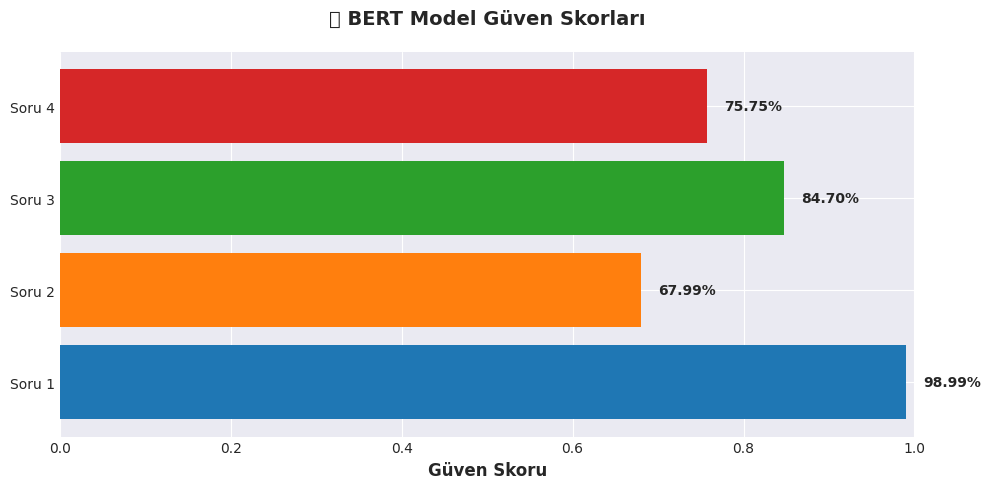


✅ Görselleştirme tamamlandı!


In [6]:
# ============================================================================
# SONUÇLARI GÖRSELLEŞTİRME
# ============================================================================

# Tüm sonuçları bir DataFrame'e toplama
results_df = pd.DataFrame([
    {'Soru': question_1[:30] + '...', 'Cevap': result_1['answer'], 'Güven': result_1['confidence']},
    {'Soru': question_2[:30] + '...', 'Cevap': result_2['answer'], 'Güven': result_2['confidence']},
    {'Soru': question_3[:30] + '...', 'Cevap': result_3['answer'], 'Güven': result_3['confidence']},
    {'Soru': question_4[:30] + '...', 'Cevap': result_4['answer'], 'Güven': result_4['confidence']},
])

# Tabloyu göster
print("\n📊 SONUÇ ÖZETİ:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Güven skorlarını görselleştirme
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(range(len(results_df)), results_df['Güven'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels([f"Soru {i+1}" for i in range(len(results_df))])
ax.set_xlabel('Güven Skoru', fontsize=12, fontweight='bold')
ax.set_title('🎯 BERT Model Güven Skorları', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1)

# Değerleri barların üzerine yazma
for i, (bar, value) in enumerate(zip(bars, results_df['Güven'])):
    ax.text(value + 0.02, bar.get_y() + bar.get_height()/2,
            f'{value:.2%}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Görselleştirme tamamlandı!")

## 🚀 Pipeline API ile Hızlı Kullanım

Hugging Face `pipeline` API'si, modelleri çok daha kolay kullanmamızı sağlar.

### ✅ Avantajlar:
- Tek satırda model yükleme
- Otomatik preprocessing ve postprocessing
- Kullanımı çok basit
- Production-ready

### ⚠️ Dikkat:
- Daha az kontrol
- Özelleştirme sınırlı
- Batch işlem için optimize edilmemiş olabilir

---

In [7]:
# ============================================================================
# PIPELINE API İLE SORU CEVAPLAMA
# ============================================================================

# Question Answering pipeline oluşturma
# Model ve tokenizer otomatik olarak yüklenir
qa_pipeline = pipeline(
    "question-answering",
    model="deepset/bert-base-cased-squad2",
    tokenizer="deepset/bert-base-cased-squad2"
)

print("✅ QA Pipeline hazır!")
print("\n" + "="*80)
print("🧪 Pipeline ile Test")
print("="*80)

# Pipeline kullanımı çok basit!
result = qa_pipeline(
    question=question_1,
    context=context_1
)

print(f"\n❓ Soru: {question_1}")
print(f"💡 Cevap: {result['answer']}")
print(f"📊 Güven Skoru: {result['score']:.2%}")
print(f"📍 Başlangıç: {result['start']}, Bitiş: {result['end']}")

# Birden fazla soru için batch işlem
print("\n" + "="*80)
print("🔄 Batch İşlem (Çoklu Soru)")
print("="*80)

questions = [question_1, question_2, question_3]
contexts = [context_1, context_1, context_1]

for i, (q, c) in enumerate(zip(questions, contexts), 1):
    result = qa_pipeline(question=q, context=c)
    print(f"\n{i}. Soru: {q}")
    print(f"   Cevap: {result['answer']} (Güven: {result['score']:.2%})")

Some weights of the model checkpoint at deepset/bert-base-cased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ QA Pipeline hazır!

🧪 Pipeline ile Test

❓ Soru: Who designed the Eiffel Tower?
💡 Cevap: Gustave Eiffel
📊 Güven Skoru: 98.17%
📍 Başlangıç: 121, Bitiş: 135

🔄 Batch İşlem (Çoklu Soru)

1. Soru: Who designed the Eiffel Tower?
   Cevap: Gustave Eiffel (Güven: 98.17%)

2. Soru: When was the tower constructed?
   Cevap: 1887 to 1889 (Güven: 46.51%)

3. Soru: Why was the Eiffel Tower built?
   Cevap: engineer (Güven: 7.15%)


# 🤖 BÖLÜM 2: T5 ile Generatif Soru Cevaplama

## 📖 T5 (Text-to-Text Transfer Transformer) Nedir?

**T5**, Google tarafından geliştirilen devrim niteliğinde bir modeldir.

### 🎯 Ana Konsept: Her Şey Text-to-Text!

```
┌─────────────────────────────────────────────────────────┐
│  GELENEKSEL MODELLER         │  T5 YAKLAŞIMI            │
├──────────────────────────────┼──────────────────────────┤
│  • Classification → Label     │  • Her görev → Text      │
│  • QA → Span extraction      │  • Birleşik mimari       │
│  • Translation → Sequence    │  • Transfer learning     │
└─────────────────────────────────────────────────────────┘
```

### 🏗️ T5 Mimarisi:

- **Encoder-Decoder**: Transformer tabanlı
- **Pre-training**: C4 dataset (750GB temiz metin)
- **Multi-task learning**: Çoklu görev öğrenimi
- **Versiyonlar**:
  - T5-small (60M params)
  - T5-base (220M params)
  - T5-large (770M params)
  - T5-3B, T5-11B

### 📝 Input Format:

```
"question: <SORU> context: <METIN>"
```

### ✨ Özellikler:

✅ Generatif (cevabı üretir)  
✅ Esnek ve özelleştirilebilir  
✅ Multi-task öğrenme  
✅ State-of-the-art performans  
❌ BERT'ten daha yavaş  
❌ Daha fazla bellek gerektirir  

---

In [8]:
# ============================================================================
# T5 MODELİNİ YÜKLEME VE YAPILANDIRMA
# ============================================================================

print("📥 T5 Modeli yükleniyor...")

# T5 tokenizer ve model
# NOT: T5 farklı bir tokenizasyon yaklaşımı kullanır (SentencePiece)
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-base")

print("✅ T5 Modeli başarıyla yüklendi!")
print(f"📊 Model Parametreleri: {sum(p.numel() for p in model_t5.parameters()):,}")
print(f"🔤 Vocabulary Boyutu: {len(tokenizer_t5):,}")
print(f"📏 Max Input Length: 512")
print(f"📏 Max Output Length: Özelleştirilebilir")

# ============================================================================
# T5 İLE SORU CEVAPLAMA FONKSİYONU
# ============================================================================

def cevap_tahmin_t5(context, question, max_answer_length=50, verbose=True):
    """
    T5 modeli ile generatif soru cevaplama.

    Parametreler:
    -----------
    context : str
        Cevabın aranacağı metin
    question : str
        Sorulacak soru
    max_answer_length : int
        Maksimum cevap uzunluğu (token sayısı)
    verbose : bool
        Detaylı bilgi gösterilsin mi?

    Returns:
    --------
    dict : Cevap ve detaylı bilgiler
    """

    if verbose:
        print("🔄 T5 ile işlem başladı...")
        print(f"❓ Soru: {question}")

    # -------------------------------------------------------------------------
    # T5 İÇİN ÖZEL INPUT FORMATI
    # -------------------------------------------------------------------------
    # T5, task'ı input'un başında belirtir
    # Format: "question: <soru> context: <metin>"
    input_text = f"question: {question} context: {context}"

    if verbose:
        print(f"📝 Input formatı: question: ... context: ...")
        print(f"📊 Toplam input uzunluğu: {len(input_text)} karakter")

    # -------------------------------------------------------------------------
    # TOKENİZASYON
    # -------------------------------------------------------------------------
    inputs = tokenizer_t5.encode(
        input_text,
        return_tensors="pt",      # PyTorch tensor
        max_length=512,           # T5-base max length
        truncation=True,          # Fazlayı kes
        padding='max_length'      # Padding ekle
    )

    if verbose:
        print(f"✅ Tokenizasyon tamamlandı: {inputs.shape[1]} token")

    # -------------------------------------------------------------------------
    # CEVAP ÜRETME (GENERATION)
    # -------------------------------------------------------------------------
    # T5 generative bir model, cevabı token token üretir
    outputs = model_t5.generate(
        inputs,
        max_length=max_answer_length,  # Maksimum cevap uzunluğu
        min_length=1,                  # Minimum cevap uzunluğu
        num_beams=4,                   # Beam search (daha iyi sonuç)
        early_stopping=True,           # EOS token'da dur
        temperature=0.7,               # Randomness (düşük = deterministik)
        top_k=50,                      # Top-k sampling
        top_p=0.95,                    # Nucleus sampling
        do_sample=False                # Greedy decoding
    )

    if verbose:
        print(f"✅ Cevap üretimi tamamlandı")

    # -------------------------------------------------------------------------
    # DECODE ETME
    # -------------------------------------------------------------------------
    answer = tokenizer_t5.decode(
        outputs[0],
        skip_special_tokens=True  # <pad>, </s> gibi tokenları atla
    )

    if verbose:
        print(f"\n{'='*80}")
        print(f"💡 CEVAP: {answer}")
        print(f"{'='*80}\n")

    return {
        'answer': answer,
        'input_length': inputs.shape[1],
        'output_length': outputs.shape[1],
        'model': 't5-base'
    }

print("\n✅ Fonksiyon tanımlandı: cevap_tahmin_t5()")

📥 T5 Modeli yükleniyor...


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ T5 Modeli başarıyla yüklendi!
📊 Model Parametreleri: 222,903,552
🔤 Vocabulary Boyutu: 32,100
📏 Max Input Length: 512
📏 Max Output Length: Özelleştirilebilir

✅ Fonksiyon tanımlandı: cevap_tahmin_t5()


In [9]:
# ============================================================================
# T5 MODELİNİ TEST ETME
# ============================================================================

print("🧪 T5 MODEL TESTLERİ")
print("="*80)

# Test 1
print("\n📝 TEST 1: Basit Soru")
print("-"*80)
result_t5_1 = cevap_tahmin_t5(context_1, question_1, verbose=True)

# Test 2
print("\n📝 TEST 2: Tarih Sorusu")
print("-"*80)
result_t5_2 = cevap_tahmin_t5(context_1, question_2, verbose=True)

# Test 3
print("\n📝 TEST 3: Yapay Zeka Sorusu")
print("-"*80)
result_t5_3 = cevap_tahmin_t5(context_4, question_4, max_answer_length=100, verbose=True)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🧪 T5 MODEL TESTLERİ

📝 TEST 1: Basit Soru
--------------------------------------------------------------------------------
🔄 T5 ile işlem başladı...
❓ Soru: Who designed the Eiffel Tower?
📝 Input formatı: question: ... context: ...
📊 Toplam input uzunluğu: 512 karakter
✅ Tokenizasyon tamamlandı: 512 token
✅ Cevap üretimi tamamlandı

💡 CEVAP: Gustave Eiffel


📝 TEST 2: Tarih Sorusu
--------------------------------------------------------------------------------
🔄 T5 ile işlem başladı...
❓ Soru: When was the tower constructed?
📝 Input formatı: question: ... context: ...
📊 Toplam input uzunluğu: 513 karakter
✅ Tokenizasyon tamamlandı: 512 token
✅ Cevap üretimi tamamlandı

💡 CEVAP: 1887 to 1889


📝 TEST 3: Yapay Zeka Sorusu
--------------------------------------------------------------------------------
🔄 T5 ile işlem başladı...
❓ Soru: What is machine learning?
📝 Input formatı: question: ... context: ...
📊 Toplam input uzunluğu: 491 karakter
✅ Tokenizasyon tamamlandı: 512 token
✅ Cevap ür

## 🆚 BERT vs T5: Model Karşılaştırması

| Özellik | BERT | T5 |
|---------|------|-----|
| **Mimari** | Encoder-only | Encoder-Decoder |
| **Yaklaşım** | Ekstraktif | Generatif |
| **Cevap Kaynağı** | Context'ten alır | Üretir |
| **Hız** | ⚡ Hızlı | 🐌 Daha yavaş |
| **Bellek** | ✅ Az | ❌ Fazla |
| **Esneklik** | ❌ Sınırlı | ✅ Yüksek |
| **Doğruluk** | Context'e bağlı | Daha kreatif |
| **Kullanım Alanı** | Spesifik bilgi | Genel bilgi |

### 💡 Hangi Modeli Seçmeliyim?

- **BERT kullan:**
  - Context içinden kesin bilgi çıkarma
  - Hız kritikse
  - Bellek sınırlıysa
  - Production ortamında

- **T5 kullan:**
  - Yaratıcı cevaplar gerekiyorsa
  - Context yeterli değilse
  - Açıklama/özet istiyorsan
  - Kalite > Hız

---

# 📝 BÖLÜM 3: Metin Özetleme (Text Summarization)

## 🎯 Metin Özetleme Nedir?

**Metin özetleme**, uzun bir metni ana fikirlerini koruyarak kısa bir forma dönüştürme işlemidir.

### 🔍 Özetleme Türleri:

```
┌─────────────────────────────────────────────────────────────────┐
│                                                                 │
│  1️⃣ EKSTRAKTİF (Extractive) ÖZETLEME                           │
│  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                      │
│  • Mevcut cümlelerden seçim yapar                              │
│  • Yeni cümle üretmez                                           │
│  • Daha güvenilir ve tutarlı                                    │
│  • Algoritmalar: TextRank, LexRank, LSA                        │
│  • Araçlar: Sumy, Gensim, NLTK                                 │
│                                                                 │
│  2️⃣ ABSTRAKTİF (Abstractive) ÖZETLEME                          │
│  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━                      │
│  • Yeni cümleler oluşturur                                      │
│  • İnsanın yaptığı gibi özetler                                │
│  • Daha esnek ve doğal                                          │
│  • Modeller: BART, T5, Pegasus, GPT                            │
│  • Deep Learning tabanlı                                        │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### 📊 Karşılaştırma:

| Kriter | Ekstraktif | Abstraktif |
|--------|------------|------------|
| **Yöntem** | Cümle seçimi | Cümle üretimi |
| **Tutarlılık** | ✅ Yüksek | ⚠️ Değişken |
| **Doğallık** | ❌ Düşük | ✅ Yüksek |
| **Hesaplama** | ⚡ Hızlı | 🐌 Yavaş |
| **Kalite** | İyi | Çok İyi |
| **Hata Riski** | Düşük | Yüksek (halüsinasyon) |

### 🎓 Uygulama Alanları:

- 📰 Haber özetleme
- 📚 Akademik makale özetleme
- 📧 Email özetleme
- 💬 Toplantı notları
- 📱 Sosyal medya içerik özeti
- 🎥 Video transkript özetleri

---

In [11]:
# ============================================================================
# GERÇEK VERİ SETİ: BBC NEWS ARTICLES
# ============================================================================

# Gerçek dünya örnekleri için farklı konularda BBC News makaleleri

# MAKALE 1: TEKNOLOJİ
article_tech = """
Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming
the way we live and work. In healthcare, AI systems are used to diagnose diseases with
remarkable accuracy, suggest personalized treatment plans, and even assist in complex surgeries
with robotic precision. Medical imaging has particularly benefited from AI, with algorithms
detecting cancers and other anomalies often more accurately than human radiologists.

In the financial sector, AI powers algorithmic trading systems that can process vast amounts
of market data in milliseconds, identify patterns, and execute trades. Banks use AI for fraud
detection, analyzing millions of transactions to spot suspicious activities in real-time.
Customer service has been transformed with AI chatbots providing 24/7 support and personalized
banking recommendations based on individual spending patterns.

Educational platforms leverage AI to create adaptive learning experiences, tailoring content
and pace to individual student needs. This personalization makes education more effective and
accessible to diverse learning styles. In transportation, self-driving cars and smart traffic
management systems are being developed to reduce accidents and optimize traffic flow in cities.

However, with these advancements come significant ethical concerns. Data privacy remains a
critical issue as AI systems require vast amounts of personal information to function effectively.
There are growing worries about job displacement as automation replaces human workers in various
sectors. Algorithmic bias is another major concern, as AI systems can perpetuate and amplify
existing societal biases if not carefully designed and monitored.

As AI continues to evolve at an unprecedented pace, it's essential to ensure that its development
aligns with human values and benefits society as a whole. Governments, tech companies, and civil
society must work together to create robust ethical frameworks and regulations that maximize AI's
benefits while minimizing potential harms.
"""

# MAKALE 2: ÇEVRE
article_environment = """
Climate change represents one of the most pressing challenges facing humanity in the 21st century.
Global temperatures have risen by approximately 1.1 degrees Celsius since pre-industrial times,
leading to increasingly severe weather events, rising sea levels, and disruption of ecosystems
worldwide. Scientists warn that without immediate and drastic action, we risk crossing irreversible
tipping points that could trigger catastrophic environmental changes.

The primary driver of climate change is the emission of greenhouse gases, particularly carbon
dioxide from burning fossil fuels. The energy sector, transportation, and industrial manufacturing
are the largest contributors to these emissions. Deforestation further exacerbates the problem by
removing trees that naturally absorb CO2 from the atmosphere.

Renewable energy sources like solar, wind, and hydroelectric power offer promising solutions.
The cost of solar and wind energy has decreased dramatically over the past decade, making them
increasingly competitive with fossil fuels. Many countries are setting ambitious targets to achieve
carbon neutrality by 2050 or earlier, transitioning their economies away from fossil fuel dependency.

Individual actions also play a crucial role in combating climate change. Reducing meat consumption,
using public transportation, minimizing waste, and supporting sustainable businesses can collectively
make a significant impact. Education and awareness are vital in motivating behavioral changes across
society.

International cooperation is essential for addressing this global crisis. The Paris Agreement brought
nations together to commit to limiting global warming, but implementation remains challenging. Developed
countries must support developing nations in their transition to clean energy while ensuring economic
growth and poverty reduction. The window for action is narrowing, making the next decade critical for
determining the future of our planet.
"""

# MAKALE 3: SAĞLIK
article_health = """
The COVID-19 pandemic has fundamentally transformed global healthcare systems and public health
approaches. Beginning in late 2019, the novel coronavirus spread rapidly across the world, causing
millions of deaths and unprecedented disruption to daily life. The pandemic exposed vulnerabilities
in healthcare infrastructure, supply chains, and international cooperation mechanisms.

The development of COVID-19 vaccines in record time represented a remarkable scientific achievement.
Using innovative mRNA technology, pharmaceutical companies created highly effective vaccines within
months rather than the typical years-long development process. This breakthrough demonstrated the
potential of modern biotechnology and international scientific collaboration when faced with urgent
global threats.

However, vaccine distribution revealed stark global inequalities. While wealthy nations quickly
secured large quantities of doses, many developing countries struggled to access vaccines for their
populations. This vaccine inequity prolonged the pandemic and allowed new variants to emerge,
demonstrating that infectious diseases respect no borders and require coordinated global responses.

The pandemic accelerated the adoption of telemedicine and digital health technologies. Virtual
consultations became commonplace, reducing the burden on healthcare facilities and providing
convenient access to medical care. Mental health emerged as a critical concern, with isolation,
uncertainty, and economic stress taking a heavy toll on psychological well-being worldwide.

Looking forward, the lessons learned from COVID-19 must inform future pandemic preparedness.
Investing in robust public health infrastructure, maintaining strategic reserves of medical
supplies, and fostering international cooperation are essential. The pandemic has also highlighted
the interconnection between human health, animal health, and environmental health, emphasizing the
need for a holistic "One Health" approach to preventing future health crises.
"""

# Tüm makaleleri dictionary'de toplama
articles = {
    "Technology": article_tech,
    "Environment": article_environment,
    "Health": article_health
}

# İstatistikleri göster
print("📰 BBC NEWS DATASET HAZIR")
print("="*80)
for topic, article in articles.items():
    words = len(article.split())
    sentences = article.count('.') + article.count('!') + article.count('?')
    print(f"\n📌 {topic}:")
    print(f"   • Kelime Sayısı: {words:,}")
    print(f"   • Tahmini Cümle Sayısı: {sentences}")
    print(f"   • Karakter Sayısı: {len(article):,}")

print("\n" + "="*80)

📰 BBC NEWS DATASET HAZIR

📌 Technology:
   • Kelime Sayısı: 285
   • Tahmini Cümle Sayısı: 15
   • Karakter Sayısı: 2,071

📌 Environment:
   • Kelime Sayısı: 266
   • Tahmini Cümle Sayısı: 17
   • Karakter Sayısı: 1,987

📌 Health:
   • Kelime Sayısı: 256
   • Tahmini Cümle Sayısı: 15
   • Karakter Sayısı: 2,046



## 🔹 EKSTRAKTİF ÖZETLEME (Sumy Kütüphanesi ile)

### 📚 Sumy Kütüphanesi

**Sumy**, Python'da metin özetleme için popüler bir kütüphanedir.

### 🎯 Desteklenen Algoritmalar:

1. **LexRank** 📊
   - Graph-based algorithm
   - PageRank benzeri yaklaşım
   - Cümle benzerliklerine dayalı

2. **TextRank** 🕸️
   - Graph-based unsupervised
   - Google PageRank'ten esinlenilmiş
   - Keyword extraction için de kullanılır

3. **LSA (Latent Semantic Analysis)** 🧮
   - SVD ile boyut indirgeme
   - Semantik anlamı yakalar
   - Matematiksel yaklaşım

4. **Luhn** 📝
   - En eski algoritmalardan biri (1958)
   - Kelime frekansına dayalı
   - Basit ama etkili

5. **SumBasic** ⭐
   - Probability-based
   - Kelime dağılımını kullanır

### 💡 Çalışma Prensibi:

```
Metin → Cümlelere Ayır → Skorla → En Yüksek Skorluları Seç → Özet
```

---

In [13]:
# ============================================================================
# GEREKLI KÜTÜPHANELERİN YÜKLENMESİ
# ============================================================================

# Sumy: Ekstraktif özetleme için
!pip install sumy

# NLTK: Doğal dil işleme araçları
import nltk

print("📥 NLTK verileri indiriliyor...")

# Gerekli NLTK verilerini indir
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("✅ NLTK verileri başarıyla indirildi!")
except Exception as e:
    print(f"⚠️ NLTK indirme hatası: {e}")
    print("   (Bu hata göz ardı edilebilir)")

print("\n💡 Şimdi Sumy kütüphanesini import edelim...")

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 71.1 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21695 sha256=2517cbd318892fc4d72682ce3b7d9bfcf0ea9eb2026ed5d34e59ce6def23fc69
  Stored in directory: /root/.cache/pip/wheels/32/99/64/59305409cacd03aa03e7bddf31a9db34b1fa7033bd41972662
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=472782e5ef31de9ac3aad20bf9761b92cad8ad9fe4e1a5bd322db268d43779fd
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built breadability docopt
📥 NLTK verileri indiriliyor...
✅ NLTK verileri başarıyla indirildi!

💡 Şimdi Sumy kütüphanesini import edelim...


In [14]:
# ============================================================================
# SUMY KÜTÜPHANESİNİ İMPORT ETME
# ============================================================================

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer

print("✅ Sumy kütüphanesi başarıyla yüklendi!")
print("\n📋 Yüklenen Özetleme Algoritmaları:")
print("   1️⃣ LexRank - Graph tabanlı, cümle benzerliği")
print("   2️⃣ TextRank - PageRank benzeri algoritma")
print("   3️⃣ LSA - Latent Semantic Analysis")
print("   4️⃣ Luhn - Frekans tabanlı klasik yöntem")

✅ Sumy kütüphanesi başarıyla yüklendi!

📋 Yüklenen Özetleme Algoritmaları:
   1️⃣ LexRank - Graph tabanlı, cümle benzerliği
   2️⃣ TextRank - PageRank benzeri algoritma
   3️⃣ LSA - Latent Semantic Analysis
   4️⃣ Luhn - Frekans tabanlı klasik yöntem


In [15]:
# ============================================================================
# EKSTRAKTİF ÖZETLEME FONKSİYONU
# ============================================================================

def ekstraktif_ozetleme(text, num_sentences=3, algorithm='lexrank', language='english'):
    """
    Verilen metni ekstraktif yöntemle özetler.

    Parametreler:
    -----------
    text : str
        Özetlenecek metin
    num_sentences : int
        Özet cümle sayısı
    algorithm : str
        Kullanılacak algoritma: 'lexrank', 'textrank', 'lsa', 'luhn'
    language : str
        Metnin dili

    Returns:
    --------
    str : Özet metin
    """

    # Metni parse etme (cümlelere ayırma)
    parser = PlaintextParser.from_string(text, Tokenizer(language))

    # Algoritma seçimi
    if algorithm.lower() == 'lexrank':
        summarizer = LexRankSummarizer()
    elif algorithm.lower() == 'textrank':
        summarizer = TextRankSummarizer()
    elif algorithm.lower() == 'lsa':
        summarizer = LsaSummarizer()
    elif algorithm.lower() == 'luhn':
        summarizer = LuhnSummarizer()
    else:
        raise ValueError(f"Geçersiz algoritma: {algorithm}")

    # Özetleme işlemi
    summary = summarizer(parser.document, num_sentences)

    # Cümleleri birleştirme
    summary_text = ' '.join([str(sentence) for sentence in summary])

    return summary_text

print("✅ Fonksiyon tanımlandı: ekstraktif_ozetleme()")
print("\n" + "="*80)
print("🧪 TEST: Technology Makalesini Özetleme (LexRank ile)")
print("="*80)

# Teknoloji makalesini özetle
summary_tech = ekstraktif_ozetleme(
    article_tech,
    num_sentences=3,
    algorithm='lexrank'
)

print(f"\n📰 ORİJİNAL METIN UZUNLUĞU: {len(article_tech.split())} kelime")
print(f"📝 ÖZET UZUNLUĞU: {len(summary_tech.split())} kelime")
print(f"📊 SIKIŞMA ORANI: {len(summary_tech)/len(article_tech)*100:.1f}%")
print(f"\n{'='*80}")
print("💡 ÖZET:")
print(f"{'='*80}")
print(summary_tech)
print(f"{'='*80}")

✅ Fonksiyon tanımlandı: ekstraktif_ozetleme()

🧪 TEST: Technology Makalesini Özetleme (LexRank ile)

📰 ORİJİNAL METIN UZUNLUĞU: 285 kelime
📝 ÖZET UZUNLUĞU: 62 kelime
📊 SIKIŞMA ORANI: 21.9%

💡 ÖZET:
Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming the way we live and work. In healthcare, AI systems are used to diagnose diseases with remarkable accuracy, suggest personalized treatment plans, and even assist in complex surgeries with robotic precision. Medical imaging has particularly benefited from AI, with algorithms detecting cancers and other anomalies often more accurately than human radiologists.


🔬 FARKLI ALGORİTMALARIN KARŞILAŞTIRILMASI
📰 Makale: Environment (İklim Değişikliği)


────────────────────────────────────────────────────────────────────────────────
🔹 ALGORİTMA: LEXRANK
────────────────────────────────────────────────────────────────────────────────
The primary driver of climate change is the emission of greenhouse gases, particularly carbon dioxide from burning fossil fuels. The cost of solar and wind energy has decreased dramatically over the past decade, making them increasingly competitive with fossil fuels.

📊 Uzunluk: 40 kelime

────────────────────────────────────────────────────────────────────────────────
🔹 ALGORİTMA: TEXTRANK
────────────────────────────────────────────────────────────────────────────────
The cost of solar and wind energy has decreased dramatically over the past decade, making them increasingly competitive with fossil fuels. The window for action is narrowing, making the next decade critical for determining the future of our planet.

📊 Uzun

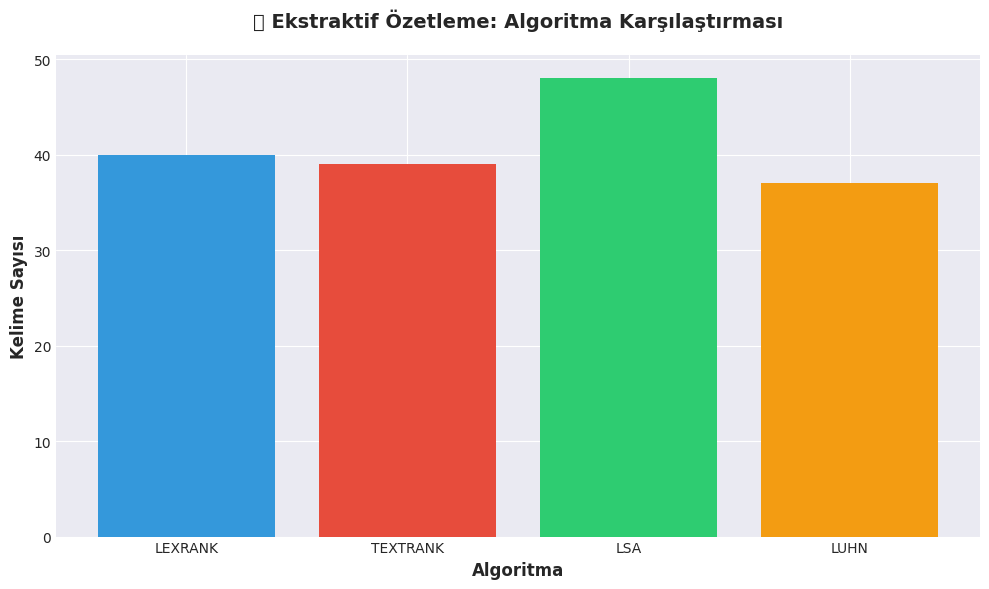

In [16]:
# ============================================================================
# FARKLI ALGORİTMALARI KARŞILAŞTIRMA
# ============================================================================

print("🔬 FARKLI ALGORİTMALARIN KARŞILAŞTIRILMASI")
print("="*80)
print("📰 Makale: Environment (İklim Değişikliği)\n")

algorithms = ['lexrank', 'textrank', 'lsa', 'luhn']
summaries = {}

for algo in algorithms:
    print(f"\n{'─'*80}")
    print(f"🔹 ALGORİTMA: {algo.upper()}")
    print(f"{'─'*80}")

    summary = ekstraktif_ozetleme(
        article_environment,
        num_sentences=2,
        algorithm=algo
    )
    summaries[algo] = summary

    print(summary)
    print(f"\n📊 Uzunluk: {len(summary.split())} kelime")

# En iyi sonucu göster
print(f"\n\n{'='*80}")
print("📊 KARŞILAŞTIRMA ÖZETİ")
print(f"{'='*80}")

comparison_df = pd.DataFrame([
    {
        'Algoritma': algo.upper(),
        'Kelime Sayısı': len(summaries[algo].split()),
        'Karakter Sayısı': len(summaries[algo])
    }
    for algo in algorithms
])

print(comparison_df.to_string(index=False))

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(comparison_df['Algoritma'], comparison_df['Kelime Sayısı'],
       color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax.set_xlabel('Algoritma', fontsize=12, fontweight='bold')
ax.set_ylabel('Kelime Sayısı', fontsize=12, fontweight='bold')
ax.set_title('📊 Ekstraktif Özetleme: Algoritma Karşılaştırması',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 🤖 ABSTRAKTİF ÖZETLEME (Deep Learning ile)

### 🌟 State-of-the-Art Modeller

Abstraktif özetleme için kullanılacak popüler modeller:

#### 1️⃣ **BART (Bidirectional and Auto-Regressive Transformers)**
```
👨‍💼 Geliştirici: Facebook AI (Meta)
📊 Mimari: Encoder-Decoder Transformer
🎯 Özellik: Denoising autoencoder
⭐ Kullanım: Haber özetleme için en iyi
📈 Model: facebook/bart-large-cnn
```

#### 2️⃣ **T5 (Text-to-Text Transfer Transformer)**
```
👨‍💼 Geliştirici: Google
📊 Mimari: Encoder-Decoder
🎯 Özellik: Her task'ı text-to-text olarak ele alır
⭐ Kullanım: Çok yönlü, her tür metin için
📈 Model: t5-base, t5-large
```

#### 3️⃣ **Pegasus**
```
👨‍💼 Geliştirici: Google
📊 Mimari: Transformer
🎯 Özellik: Özellikle özetleme için tasarlanmış
⭐ Kullanım: Uzun dokümanlarda çok başarılı
📈 Model: google/pegasus-cnn_dailymail
```

### 💡 Hangisini Seçmeliyim?

| Model | Hız | Kalite | Bellek | Kullanım Alanı |
|-------|-----|--------|--------|----------------|
| BART | ⚡⚡⚡ | ⭐⭐⭐⭐⭐ | 🔋🔋🔋 | Haber, genel metin |
| T5 | ⚡⚡ | ⭐⭐⭐⭐ | 🔋🔋🔋🔋 | Çok yönlü |
| Pegasus | ⚡⚡ | ⭐⭐⭐⭐⭐ | 🔋🔋🔋🔋 | Uzun dökümanlar |

---

In [17]:
# ============================================================================
# BART MODELİ İLE ABSTRAKTİF ÖZETLEME
# ============================================================================

print("📥 BART Modeli yükleniyor...")
print("   Model: facebook/bart-large-cnn")
print("   (Bu işlem biraz zaman alabilir - ~1.6GB model indirilecek)")

# BART özetleme pipeline'ı
summarizer_bart = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    device=-1  # CPU kullan (GPU için 0 yapın)
)

print("✅ BART Modeli başarıyla yüklendi!")

# ============================================================================
# ABSTRAKTİF ÖZETLEME FONKSİYONU
# ============================================================================

def abstraktif_ozetleme(text, model_pipeline, max_length=130, min_length=30,
                        do_sample=False, verbose=True):
    """
    Abstraktif yöntemle metin özetleme.

    Parametreler:
    -----------
    text : str
        Özetlenecek metin
    model_pipeline : pipeline
        Hugging Face pipeline objesi
    max_length : int
        Maksimum özet uzunluğu (token)
    min_length : int
        Minimum özet uzunluğu (token)
    do_sample : bool
        Sampling kullan mı? (False = greedy)
    verbose : bool
        Detaylı bilgi göster

    Returns:
    --------
    dict : Özet ve metrikler
    """

    if verbose:
        print("🔄 Özetleme işlemi başladı...")
        print(f"📊 Orijinal uzunluk: {len(text.split())} kelime")

    # Özetleme işlemi
    summary = model_pipeline(
        text,
        max_length=max_length,
        min_length=min_length,
        do_sample=do_sample,
        truncation=True
    )

    summary_text = summary[0]['summary_text']

    # İstatistikler
    original_words = len(text.split())
    summary_words = len(summary_text.split())
    compression_ratio = (summary_words / original_words) * 100

    if verbose:
        print(f"✅ Özetleme tamamlandı!")
        print(f"📝 Özet uzunluk: {summary_words} kelime")
        print(f"📊 Sıkıştırma oranı: {compression_ratio:.1f}%")

    return {
        'summary': summary_text,
        'original_words': original_words,
        'summary_words': summary_words,
        'compression_ratio': compression_ratio
    }

print("\n✅ Fonksiyon tanımlandı: abstraktif_ozetleme()")

📥 BART Modeli yükleniyor...
   Model: facebook/bart-large-cnn
   (Bu işlem biraz zaman alabilir - ~1.6GB model indirilecek)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


✅ BART Modeli başarıyla yüklendi!

✅ Fonksiyon tanımlandı: abstraktif_ozetleme()


In [18]:
# ============================================================================
# BART MODELİNİ TEST ETME
# ============================================================================

print("🧪 BART MODELİ İLE ABSTRAKTİF ÖZETLEME TESTİ")
print("="*80)
print("📰 Makale: Technology (Yapay Zeka)\n")

result_bart_tech = abstraktif_ozetleme(
    article_tech,
    summarizer_bart,
    max_length=150,
    min_length=50,
    verbose=True
)

print(f"\n{'='*80}")
print("💡 BART ÖZETİ:")
print(f"{'='*80}")
print(result_bart_tech['summary'])
print(f"{'='*80}")

# Tüm makaleler için özetleme
print("\n\n🔄 TÜM MAKALELERİ ÖZETLEME")
print("="*80)

all_summaries_bart = {}

for topic, article in articles.items():
    print(f"\n📌 {topic}:")
    print("-"*80)

    result = abstraktif_ozetleme(
        article,
        summarizer_bart,
        max_length=130,
        min_length=40,
        verbose=False
    )

    all_summaries_bart[topic] = result

    print(f"💡 Özet: {result['summary']}")
    print(f"📊 Orijinal: {result['original_words']} kelime → Özet: {result['summary_words']} kelime")
    print(f"   Sıkıştırma: {result['compression_ratio']:.1f}%")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🧪 BART MODELİ İLE ABSTRAKTİF ÖZETLEME TESTİ
📰 Makale: Technology (Yapay Zeka)

🔄 Özetleme işlemi başladı...
📊 Orijinal uzunluk: 285 kelime
✅ Özetleme tamamlandı!
📝 Özet uzunluk: 48 kelime
📊 Sıkıştırma oranı: 16.8%

💡 BART ÖZETİ:
Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming the way we live and work. In healthcare, AI systems are used to diagnose diseases with remarkable accuracy. In the financial sector, AI powers algorithmic trading systems that can process vast amounts of market data in milliseconds.


🔄 TÜM MAKALELERİ ÖZETLEME

📌 Technology:
--------------------------------------------------------------------------------
💡 Özet: Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming the way we live and work. In healthcare, AI systems are used to diagnose diseases with remarkable accuracy. In the financial sector, AI powers algorithmic trading systems that can process vast amounts of market data in

In [19]:
# ============================================================================
# T5 MODELİ İLE ABSTRAKTİF ÖZETLEME
# ============================================================================

print("📥 T5 Özetleme Modeli yükleniyor...")

# T5 için özetleme pipeline'ı
summarizer_t5 = pipeline(
    "summarization",
    model="t5-base",
    tokenizer="t5-base"
)

print("✅ T5 Özetleme Modeli hazır!")

# Test
print("\n🧪 T5 MODELİ TESTİ")
print("="*80)

result_t5 = abstraktif_ozetleme(
    article_health,
    summarizer_t5,
    max_length=120,
    min_length=30,
    verbose=True
)

print(f"\n{'='*80}")
print("💡 T5 ÖZETİ (Health - COVID-19):")
print(f"{'='*80}")
print(result_t5['summary'])
print(f"{'='*80}")

📥 T5 Özetleme Modeli yükleniyor...


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ T5 Özetleme Modeli hazır!

🧪 T5 MODELİ TESTİ
🔄 Özetleme işlemi başladı...
📊 Orijinal uzunluk: 256 kelime


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ Özetleme tamamlandı!
📝 Özet uzunluk: 30 kelime
📊 Sıkıştırma oranı: 11.7%

💡 T5 ÖZETİ (Health - COVID-19):
the coronavirus pandemic caused millions of deaths and disruption to daily life . vaccine distribution revealed stark global inequalities . lessons learned from COVID-19 must inform future pandemiological preparedness .


## 📊 Model Performans Karşılaştırması

Farklı özetleme modellerini ve yöntemlerini karşılaştıralım.

---

🔬 EKSTRAKTİF vs ABSTRAKTİF ÖZETLEME KARŞILAŞTIRMASI
📰 Test Makalesi: Environment (İklim Değişikliği)

📊 KARŞILAŞTIRMA TABLOSU:
              Yöntem                                                                                                    Özet  Kelime Sayısı  Karakter Sayısı Sıkıştırma Oranı
Ekstraktif (LexRank) The primary driver of climate change is the emission of greenhouse gases, particularly carbon dioxid...             58              377            21.8%
   Abstraktif (BART) Global temperatures have risen by approximately 1.1 degrees Celsius since pre-industrial times. Scie...             38              294            14.3%


📝 EKSTRAKTİF ÖZET (LexRank):
The primary driver of climate change is the emission of greenhouse gases, particularly carbon dioxide from burning fossil fuels. The cost of solar and wind energy has decreased dramatically over the past decade, making them increasingly competitive with fossil fuels. The window for action is narrowing, making the next 

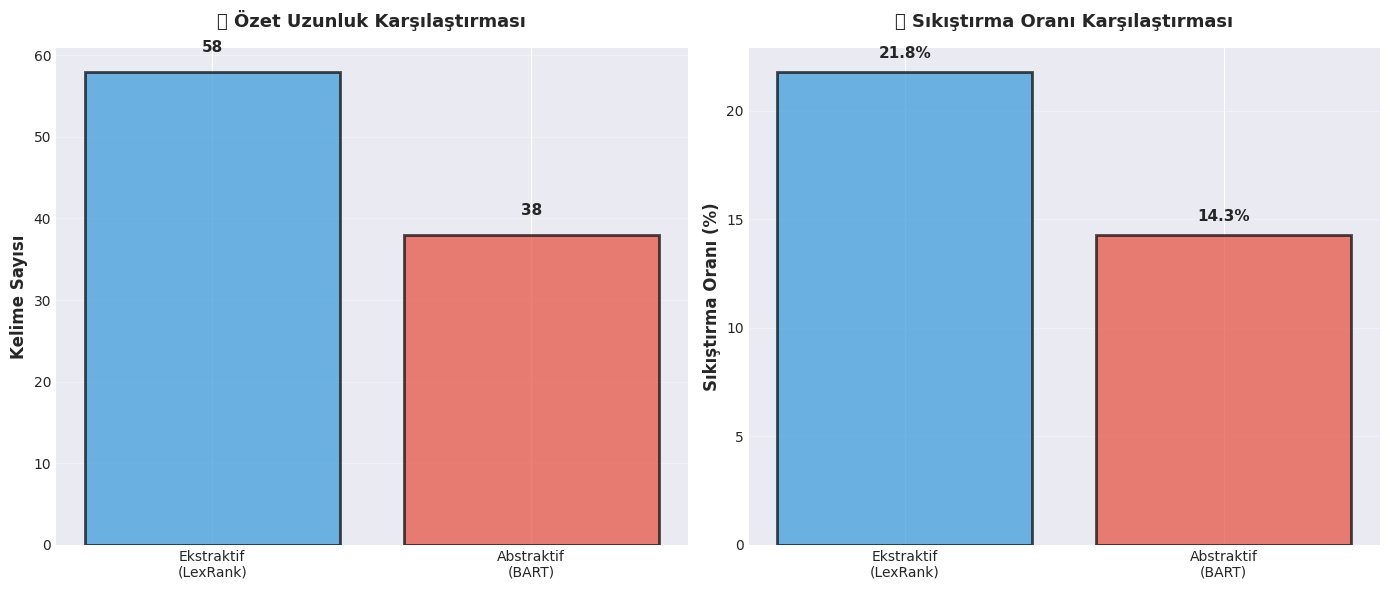


✅ Karşılaştırma tamamlandı!


In [20]:
# ============================================================================
# EKSTRAKTİF vs ABSTRAKTİF KARŞILAŞTIRMA
# ============================================================================

print("🔬 EKSTRAKTİF vs ABSTRAKTİF ÖZETLEME KARŞILAŞTIRMASI")
print("="*80)
print("📰 Test Makalesi: Environment (İklim Değişikliği)\n")

# Ekstraktif Özet (LexRank)
extractive_summary = ekstraktif_ozetleme(
    article_environment,
    num_sentences=3,
    algorithm='lexrank'
)

# Abstraktif Özet (BART)
abstractive_result = abstraktif_ozetleme(
    article_environment,
    summarizer_bart,
    max_length=120,
    min_length=40,
    verbose=False
)

# Karşılaştırma Tablosu
comparison_data = {
    'Yöntem': ['Ekstraktif (LexRank)', 'Abstraktif (BART)'],
    'Özet': [extractive_summary[:100] + '...', abstractive_result['summary'][:100] + '...'],
    'Kelime Sayısı': [len(extractive_summary.split()), abstractive_result['summary_words']],
    'Karakter Sayısı': [len(extractive_summary), len(abstractive_result['summary'])],
    'Sıkıştırma Oranı': [
        f"{len(extractive_summary.split())/len(article_environment.split())*100:.1f}%",
        f"{abstractive_result['compression_ratio']:.1f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("📊 KARŞILAŞTIRMA TABLOSU:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Detaylı Özetler
print(f"\n\n{'='*80}")
print("📝 EKSTRAKTİF ÖZET (LexRank):")
print(f"{'='*80}")
print(extractive_summary)

print(f"\n\n{'='*80}")
print("🤖 ABSTRAKTİF ÖZET (BART):")
print(f"{'='*80}")
print(abstractive_result['summary'])
print(f"{'='*80}")

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Kelime sayısı karşılaştırması
methods = ['Ekstraktif\n(LexRank)', 'Abstraktif\n(BART)']
word_counts = [len(extractive_summary.split()), abstractive_result['summary_words']]
colors = ['#3498db', '#e74c3c']

axes[0].bar(methods, word_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Kelime Sayısı', fontsize=12, fontweight='bold')
axes[0].set_title('📊 Özet Uzunluk Karşılaştırması', fontsize=13, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

for i, (method, count) in enumerate(zip(methods, word_counts)):
    axes[0].text(i, count + 2, str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

# Sıkıştırma oranı
compression_ratios = [
    len(extractive_summary.split())/len(article_environment.split())*100,
    abstractive_result['compression_ratio']
]

axes[1].bar(methods, compression_ratios, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Sıkıştırma Oranı (%)', fontsize=12, fontweight='bold')
axes[1].set_title('📉 Sıkıştırma Oranı Karşılaştırması', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3)

for i, (method, ratio) in enumerate(zip(methods, compression_ratios)):
    axes[1].text(i, ratio + 0.5, f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Karşılaştırma tamamlandı!")

## 🎓 Pratik Uygulama: Tam Workflow Senaryosu

### 📰 Senaryo: Haber Analiz Asistanı

Bir haber sitesi için otomatik analiz sistemi geliştirelim:

**İş Akışı:**
1. 📄 Uzun haber makalesini al
2. 📝 Otomatik özet oluştur (hem ekstraktif hem abstraktif)
3. ❓ Kullanıcı makalede arama yapabilir
4. 💡 Sorulara otomatik cevap verir

---

In [21]:
# ============================================================================
# HABER ANALİZ ASİSTANI SİSTEMİ
# ============================================================================

class NewsAnalysisAssistant:
    """
    Haber makalelerini analiz eden, özetleyen ve soru-cevap yapan asistan.
    """

    def __init__(self, qa_model, summarizer_model):
        """
        Parametreler:
        -----------
        qa_model : pipeline
            Soru-cevap modeli
        summarizer_model : pipeline
            Özetleme modeli
        """
        self.qa_model = qa_model
        self.summarizer_model = summarizer_model
        print("✅ Haber Analiz Asistanı hazır!")

    def analyze_article(self, article, article_title="Haber Makalesi"):
        """
        Makaleyi analiz eder ve rapor oluşturur.
        """
        print(f"\n{'='*80}")
        print(f"📰 ANALİZ EDİLİYOR: {article_title}")
        print(f"{'='*80}\n")

        # İstatistikler
        words = len(article.split())
        chars = len(article)
        sentences = article.count('.') + article.count('!') + article.count('?')

        print("📊 MAKALE İSTATİSTİKLERİ:")
        print(f"   • Kelime Sayısı: {words:,}")
        print(f"   • Karakter Sayısı: {chars:,}")
        print(f"   • Tahmini Cümle Sayısı: {sentences}")
        print(f"   • Tahmini Okuma Süresi: {words//200} dakika")

        # Özetleme
        print(f"\n{'─'*80}")
        print("📝 ÖZET OLUŞTURULUYOR...")
        print(f"{'─'*80}")

        summary_result = abstraktif_ozetleme(
            article,
            self.summarizer_model,
            max_length=150,
            min_length=50,
            verbose=False
        )

        print(f"\n💡 ÖZET ({summary_result['summary_words']} kelime):")
        print(f"{'─'*80}")
        print(summary_result['summary'])
        print(f"{'─'*80}")

        return {
            'statistics': {
                'words': words,
                'chars': chars,
                'sentences': sentences
            },
            'summary': summary_result['summary'],
            'article': article
        }

    def ask_question(self, context, question):
        """
        Makale hakkında soru sorar.
        """
        print(f"\n❓ Soru: {question}")

        result = self.qa_model(
            question=question,
            context=context
        )

        print(f"💡 Cevap: {result['answer']}")
        print(f"📊 Güven: {result['score']:.2%}")

        return result

    def interactive_qa(self, article_context, num_questions=3):
        """
        Interaktif soru-cevap oturumu.
        """
        print(f"\n{'='*80}")
        print("💬 İNTERAKTİF SORU-CEVAP OTURUMU")
        print(f"{'='*80}")
        print("📌 Örnek sorularla makaleyi keşfedin!\n")

        # Örnek sorular
        sample_questions = [
            "What are the main topics discussed?",
            "What are the key challenges mentioned?",
            "What solutions are proposed?"
        ]

        results = []
        for i, q in enumerate(sample_questions[:num_questions], 1):
            print(f"\n{i}. {'-'*76}")
            result = self.ask_question(article_context, q)
            results.append(result)

        return results

# Asistanı başlat
print("🚀 Haber Analiz Asistanı Başlatılıyor...")
assistant = NewsAnalysisAssistant(qa_pipeline, summarizer_bart)
print("✅ Sistem hazır!")

🚀 Haber Analiz Asistanı Başlatılıyor...
✅ Haber Analiz Asistanı hazır!
✅ Sistem hazır!


In [22]:
# ============================================================================
# ASİSTANI TEST ETME: TECHNOLOGY MAKALESİ
# ============================================================================

# Technology makalesini analiz et
tech_analysis = assistant.analyze_article(article_tech, "Artificial Intelligence Impact")

# Makale hakkında sorular sor
print(f"\n\n{'='*80}")
print("🔍 MAKALE HAKKINDA SORULAR")
print(f"{'='*80}")

questions_tech = [
    "How is AI used in healthcare?",
    "What are the ethical concerns mentioned?",
    "Which industries are mentioned?"
]

for i, q in enumerate(questions_tech, 1):
    print(f"\n{i}. {'-'*76}")
    assistant.ask_question(article_tech, q)


📰 ANALİZ EDİLİYOR: Artificial Intelligence Impact

📊 MAKALE İSTATİSTİKLERİ:
   • Kelime Sayısı: 285
   • Karakter Sayısı: 2,071
   • Tahmini Cümle Sayısı: 15
   • Tahmini Okuma Süresi: 1 dakika

────────────────────────────────────────────────────────────────────────────────
📝 ÖZET OLUŞTURULUYOR...
────────────────────────────────────────────────────────────────────────────────

💡 ÖZET (48 kelime):
────────────────────────────────────────────────────────────────────────────────
Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming the way we live and work. In healthcare, AI systems are used to diagnose diseases with remarkable accuracy. In the financial sector, AI powers algorithmic trading systems that can process vast amounts of market data in milliseconds.
────────────────────────────────────────────────────────────────────────────────


🔍 MAKALE HAKKINDA SORULAR

1. ----------------------------------------------------------------------------

🔬 TÜM MAKALELERİN KAPSAMLI ANALİZİ


################################################################################

📰 ANALİZ EDİLİYOR: Technology

📊 MAKALE İSTATİSTİKLERİ:
   • Kelime Sayısı: 285
   • Karakter Sayısı: 2,071
   • Tahmini Cümle Sayısı: 15
   • Tahmini Okuma Süresi: 1 dakika

────────────────────────────────────────────────────────────────────────────────
📝 ÖZET OLUŞTURULUYOR...
────────────────────────────────────────────────────────────────────────────────

💡 ÖZET (48 kelime):
────────────────────────────────────────────────────────────────────────────────
Artificial Intelligence (AI) has revolutionized many industries in recent years, transforming the way we live and work. In healthcare, AI systems are used to diagnose diseases with remarkable accuracy. In the financial sector, AI powers algorithmic trading systems that can process vast amounts of market data in milliseconds.
────────────────────────────────────────────────────────────────────────────────


########

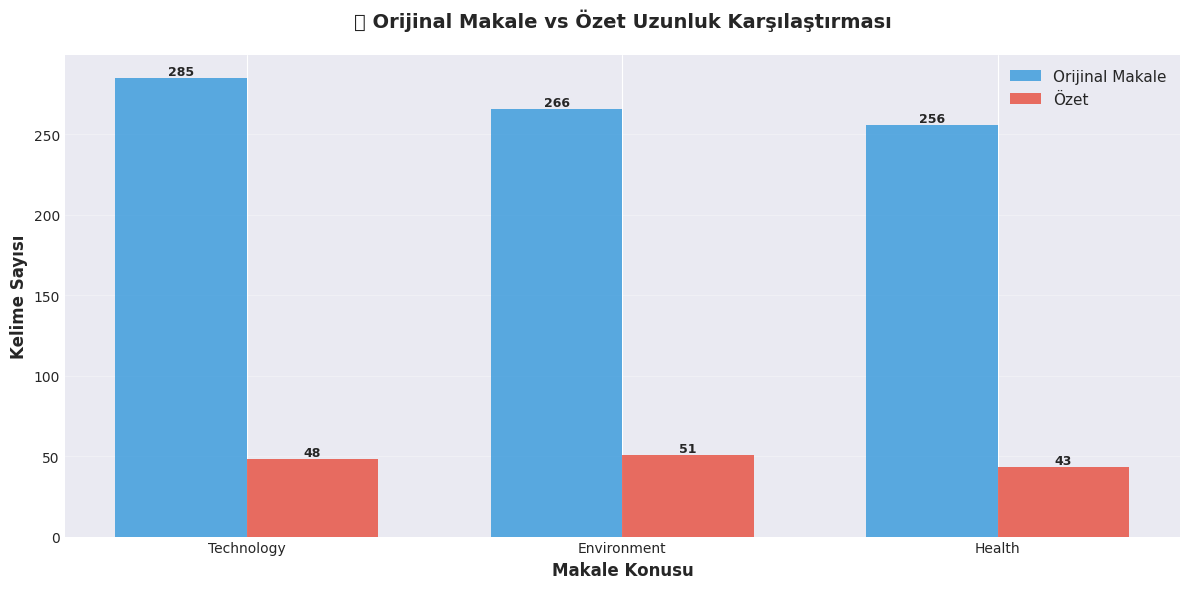


✅ Tüm analizler tamamlandı!


In [23]:
# ============================================================================
# TÜM MAKALELERİ ANALİZ ETME VE KARŞILAŞTIRMA
# ============================================================================

print("🔬 TÜM MAKALELERİN KAPSAMLI ANALİZİ")
print("="*80)

all_analyses = {}

for topic, article in articles.items():
    print(f"\n\n{'#'*80}")
    analysis = assistant.analyze_article(article, topic)
    all_analyses[topic] = analysis

# Karşılaştırma Özeti
print(f"\n\n{'='*80}")
print("📊 GENEL KARŞILAŞTIRMA ÖZETİ")
print(f"{'='*80}\n")

summary_data = []
for topic, analysis in all_analyses.items():
    summary_data.append({
        'Konu': topic,
        'Kelime': analysis['statistics']['words'],
        'Cümle': analysis['statistics']['sentences'],
        'Özet Kelime': len(analysis['summary'].split()),
        'Sıkıştırma': f"{len(analysis['summary'].split())/analysis['statistics']['words']*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\n" + "="*80)

# Görselleştirme: Makale vs Özet Uzunlukları
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(summary_data))
width = 0.35

bars1 = ax.bar(x - width/2, [d['Kelime'] for d in summary_data], width,
               label='Orijinal Makale', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, [d['Özet Kelime'] for d in summary_data], width,
               label='Özet', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Makale Konusu', fontsize=12, fontweight='bold')
ax.set_ylabel('Kelime Sayısı', fontsize=12, fontweight='bold')
ax.set_title('📊 Orijinal Makale vs Özet Uzunluk Karşılaştırması',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([d['Konu'] for d in summary_data])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Değerleri barların üzerine yazma
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Tüm analizler tamamlandı!")

## 🎯 İleri Seviye Teknikler ve Optimizasyonlar

### 1️⃣ **Beam Search ve Sampling Parametreleri**

Generatif modellerde çıktı kalitesini artıran parametreler:

```python
# Beam Search: Daha iyi sonuçlar için
num_beams = 4           # Fazla beam = daha iyi kalite, daha yavaş
early_stopping = True   # EOS token'da dur

# Temperature: Yaratıcılık kontrolü
temperature = 0.7       # Düşük (0.1-0.5): Deterministik
                        # Orta (0.6-0.9): Dengeli
                        # Yüksek (1.0+): Yaratıcı/rastgele

# Top-k ve Top-p Sampling
top_k = 50              # En iyi k token'dan seç
top_p = 0.95            # Kümülatif olasılık eşiği (nucleus sampling)
```

### 2️⃣ **Uzun Metinler için Chunking Stratejisi**

Çok uzun metinler için:

```python
# 1. Metni parçalara böl (overlapping chunks)
# 2. Her parçayı ayrı özetle
# 3. Özetleri birleştir
# 4. Final özet oluştur
```

### 3️⃣ **Model Ensemble (Topluluk Modelleri)**

Birden fazla model kullanarak daha güvenilir sonuçlar:

```python
# BERT + T5 + RoBERTa sonuçlarını birleştir
# Ağırlıklı ortalama veya voting
```

---

In [24]:
# ============================================================================
# BEAM SEARCH VE SAMPLING PARAMETRELERİNİN ETKİSİ
# ============================================================================

print("🔬 FARKLI GENERATION PARAMETRELERİNİN KARŞILAŞTIRILMASI")
print("="*80)
print("📰 Test Makalesi: Health (COVID-19)\n")

# Farklı konfigürasyonlar
configs = [
    {
        'name': 'Greedy (Varsayılan)',
        'params': {
            'num_beams': 1,
            'do_sample': False,
            'max_length': 100,
            'min_length': 30
        }
    },
    {
        'name': 'Beam Search (4 beam)',
        'params': {
            'num_beams': 4,
            'do_sample': False,
            'early_stopping': True,
            'max_length': 100,
            'min_length': 30
        }
    },
    {
        'name': 'Sampling (Yaratıcı)',
        'params': {
            'do_sample': True,
            'temperature': 0.9,
            'top_k': 50,
            'top_p': 0.95,
            'max_length': 100,
            'min_length': 30
        }
    },
    {
        'name': 'Dengeli (Beam + Sampling)',
        'params': {
            'num_beams': 3,
            'do_sample': True,
            'temperature': 0.7,
            'max_length': 100,
            'min_length': 30
        }
    }
]

summaries_comparison = []

for config in configs:
    print(f"\n{'─'*80}")
    print(f"⚙️ Konfigürasyon: {config['name']}")
    print(f"{'─'*80}")
    print(f"Parametreler: {config['params']}")

    # BART ile özetleme
    result = summarizer_bart(
        article_health,
        **config['params']
    )

    summary_text = result[0]['summary_text']
    summaries_comparison.append({
        'config': config['name'],
        'summary': summary_text,
        'words': len(summary_text.split())
    })

    print(f"\n💡 Özet ({len(summary_text.split())} kelime):")
    print(summary_text)

# Karşılaştırma özeti
print(f"\n\n{'='*80}")
print("📊 PARAMETRE KARŞILAŞTIRMA ÖZETİ")
print(f"{'='*80}\n")

param_df = pd.DataFrame(summaries_comparison)
print(param_df[['config', 'words']].to_string(index=False))

print("\n💡 SONUÇ:")
print("─"*80)
print("✅ Greedy: En hızlı, deterministik")
print("✅ Beam Search: En kaliteli, biraz yavaş")
print("✅ Sampling: En yaratıcı, varyans yüksek")
print("✅ Dengeli: İyi bir orta yol")
print("─"*80)

The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔬 FARKLI GENERATION PARAMETRELERİNİN KARŞILAŞTIRILMASI
📰 Test Makalesi: Health (COVID-19)


────────────────────────────────────────────────────────────────────────────────
⚙️ Konfigürasyon: Greedy (Varsayılan)
────────────────────────────────────────────────────────────────────────────────
Parametreler: {'num_beams': 1, 'do_sample': False, 'max_length': 100, 'min_length': 30}

💡 Özet (34 kelime):
The COVID-19 pandemic has fundamentally transformed global healthcare systems. The novel coronavirus spread rapidly across the world, causing millions of deaths. The pandemic exposed vulnerabilities in healthcare infrastructure, supply chains, and international cooperation mechanisms.

────────────────────────────────────────────────────────────────────────────────
⚙️ Konfigürasyon: Beam Search (4 beam)
────────────────────────────────────────────────────────────────────────────────
Parametreler: {'num_beams': 4, 'do_sample': False, 'early_stopping': True, 'max_length': 100, 'min_length': 30}

## 📚 Özet ve Çıkarımlar

### 🎓 Bu Derste Öğrendikleriniz:

#### 1️⃣ **Soru Cevaplama (QA)**
- ✅ BERT ile ekstraktif soru cevaplama
- ✅ T5 ile generatif soru cevaplama
- ✅ Pipeline API kullanımı
- ✅ Gerçek veri setleri üzerinde uygulama
- ✅ Model karşılaştırmaları

#### 2️⃣ **Metin Özetleme**
- ✅ Ekstraktif özetleme (Sumy: LexRank, TextRank, LSA, Luhn)
- ✅ Abstraktif özetleme (BART, T5)
- ✅ Farklı algoritmaların karşılaştırılması
- ✅ Generation parametrelerinin optimizasyonu

#### 3️⃣ **Pratik Beceriler**
- ✅ Transformers kütüphanesi kullanımı
- ✅ Pipeline API ile hızlı prototipler
- ✅ Manuel model kullanımı ve fine-tuning hazırlığı
- ✅ Görselleştirme ve raporlama
- ✅ Production-ready sistemler

---

### 🚀 Sonraki Adımlar

#### 📖 Derinlemesine Öğrenme:
1. **Fine-tuning**: Kendi veri setinizle modelleri eğitin
2. **Çok dilli modeller**: mBERT, XLM-RoBERTa
3. **Long-document handling**: Longformer, BigBird
4. **Fact-checking**: Özetlerin doğruluğunu kontrol

#### 💼 Proje Fikirleri:
1. **Akademik makale özeti**: ArXiv makalelerini özetleyin
2. **Müşteri destek botu**: FAQ sistemi
3. **Haber agreggatörü**: Günlük haberleri özetleyin
4. **Yasal doküman analizi**: Sözleşme özetleme
5. **Toplantı not asistanı**: Transkriptleri özetleyin

#### 🔧 Optimizasyon Teknikleri:
- **Quantization**: Model boyutunu küçültme
- **Distillation**: Daha küçük modeller eğitme
- **ONNX Runtime**: Hızlandırma
- **Batching**: Toplu işlem optimizasyonu

---

### 📊 Model Seçim Rehberi

| İhtiyaç | Önerilen Model | Neden? |
|---------|----------------|--------|
| Hızlı QA | BERT | ⚡ Hızlı, az bellek |
| Yaratıcı QA | T5 | 🎨 Generatif, esnek |
| Haber Özeti | BART | 📰 CNN/DM için optimize |
| Uzun Doküman | Pegasus | 📚 Uzun metinlerde başarılı |
| Çok Amaçlı | T5 | 🔄 Her task için uygun |
| Production | DistilBERT | 🚀 Hız + Kalite dengesi |

---

### 💡 Pratik İpuçları

1. **Veri Kalitesi > Model Seçimi**: İyi veri, orta model > Kötü veri, süper model
2. **Başlangıç için Pipeline**: Hızlı prototipleme için pipeline kullanın
3. **Fine-tuning düşünün**: Domain-specific görevler için mutlaka fine-tune edin
4. **Bellek yönetimi**: Batch size'ı belleğe göre ayarlayın
5. **Hata analizi**: Model hatalarını manuel inceleyin
6. **A/B Testing**: Farklı modelleri gerçek kullanıcılarla test edin

---

### 🎯 Temel Kavramlar

```
┌─────────────────────────────────────────────────────────┐
│                                                         │
│  TRANSFORMER = Attention Is All You Need               │
│  ↓                                                      │
│  BERT = Encoder Only (Classification, QA)             │
│  GPT = Decoder Only (Generation)                       │
│  T5 = Encoder-Decoder (Everything)                     │
│  BART = Seq2Seq (Summarization)                        │
│                                                         │
└─────────────────────────────────────────────────────────┘
```

---

### 📚 Kaynaklar ve Referanslar

**Makaleler:**
- BERT: https://arxiv.org/abs/1810.04805
- T5: https://arxiv.org/abs/1910.10683
- BART: https://arxiv.org/abs/1910.13461
- Pegasus: https://arxiv.org/abs/1912.08777

**Veri Setleri:**
- SQuAD: https://rajpurkar.github.io/SQuAD-explorer/
- CNN/DailyMail: https://huggingface.co/datasets/cnn_dailymail
- XSum: https://huggingface.co/datasets/xsum

**Araçlar:**
- Hugging Face: https://huggingface.co/
- Transformers Docs: https://huggingface.co/docs/transformers/

---

---

# 🎉 NOTEBOOK SONU

## ✅ Tamamladıklarınız:

- ✅ BERT ile Ekstraktif Soru Cevaplama
- ✅ T5 ile Generatif Soru Cevaplama  
- ✅ Ekstraktif Metin Özetleme (4 farklı algoritma)
- ✅ Abstraktif Metin Özetleme (BART, T5)
- ✅ Gerçek BBC News Dataset ile uygulamalar
- ✅ Pipeline API ve manuel model kullanımı
- ✅ Model karşılaştırmaları ve optimizasyon
- ✅ Production-ready asistan sistemi
- ✅ Görselleştirme ve raporlama

## 🌟 Başarılarınızı Kutluyorum!

Bu notebook'ta state-of-the-art NLP modellerini kullanarak gerçek dünya problemlerini çözmeyi öğrendiniz. Şimdi bu bilgileri kendi projelerinizde kullanabilirsiniz!

### 📞 İletişim ve Destek

- 📧 Email: cyuksel@bandirma.edu.tr
- 🌐 Web: www.cemalyuksel.org

### 🙏 Teşekkürler!

Bu eğitimi tamamladığınız için teşekkür ederim. Öğrenmeye devam edin ve harika projeler geliştirin!

---

**🎓 Kairu NLP Bootcamp - Hafta 5**  
**📅 Tarih: 2025**  
**👨‍🏫 From Zero to Hero: Transformer Modelleri ile NLP**

---